# Import Relevant Packages

In [1]:
from __future__ import print_function
#from csky.ipyconfig import *
from csky import bk, analysis, coord, dists, hyp, inj, llh, pdf, selections, trial, utils
import histlite as hl
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

mp_cpus = 15

# Load analysis data sets

In [2]:
ana_dir = utils.ensure_dir ('/data/user/drysewyk/csky_cache/ana')
repo = selections.mrichman_repo
# cp /data/user/mrichman/data/analyses/* ...
#repo = selections.Repository(local_root='/data/user/drysewyk/data/analyses',remote_root='/data/ana/analyses')

In [3]:
ana_7gfu = analysis.Analysis (repo, selections.PSDataSpecs.ps_7yr + selections.GFUDataSpecs.gfu_3yr, dir=ana_dir)

Setting up Analysis for:
IC40, IC59, IC79, IC86_2011, IC86_2012_2014, GFU_2015_2017
Setting up IC40...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC40.subanalysis.npy    
Setting up IC59...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC59.subanalysis.npy    
Setting up IC79...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC79.subanalysis.npy    
Setting up IC86_2011...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_exp.npy ...
<- /data/user/drysewyk/c

In [3]:
ana_mese = analysis.Analysis (repo, selections.MESEDataSpecs.mesc_7yr_dnn, dir=ana_dir)

Setting up Analysis for:
MESC_2010_2016_DNN
Setting up MESC_2010_2016_DNN...
Reading /data/user/mrichman/data/analyses/mese/current/mese_cascades_MC_2013_dnn.npy ...
Reading /data/user/mrichman/data/analyses/mese/current/mese_cascades_2010_2016_dnn.npy ...
<- /data/user/drysewyk/csky_cache/ana/MESC_2010_2016_DNN.subanalysis.npy    
Done.


In [5]:
#ana_mese.save(ana_dir)

In [7]:
ana_7 = analysis.Analysis (repo, selections.PSDataSpecs.ps_7yr, dir=ana_dir)

Setting up Analysis for:
IC40, IC59, IC79, IC86_2011, IC86_2012_2014
Setting up IC40...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC40_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC40.subanalysis.npy    
Setting up IC59...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC59_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC59.subanalysis.npy    
Setting up IC79...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC79_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/IC79.subanalysis.npy    
Setting up IC86_2011...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_MC.npy ...
Reading /data/user/mrichman/data/analyses/ps_tracks/current/IC86_2011_exp.npy ...
<- /data/user/drysewyk/csky_cache/ana/I

In [7]:
ana_tc = analysis.Analysis (repo, selections.PSDataSpecs.ps_7yr+selections.MESEDataSpecs.mesc_7yr_dnn, dir=ana_dir)

Setting up Analysis for:
IC40, IC59, IC79, IC86_2011, IC86_2012_2014, MESC_2010_2016_DNN
Setting up IC40...
<- /data/user/drysewyk/csky_cache/ana/IC40.subanalysis.npy    
Setting up IC59...
<- /data/user/drysewyk/csky_cache/ana/IC59.subanalysis.npy    
Setting up IC79...
<- /data/user/drysewyk/csky_cache/ana/IC79.subanalysis.npy    
Setting up IC86_2011...
<- /data/user/drysewyk/csky_cache/ana/IC86_2011.subanalysis.npy    
Setting up IC86_2012_2014...
<- /data/user/drysewyk/csky_cache/ana/IC86_2012_2014.subanalysis.npy    
Setting up MESC_2010_2016_DNN...
<- /data/user/drysewyk/csky_cache/ana/MESC_2010_2016_DNN.subanalysis.npy    
Done.


# Point Source (TXS 0506+056)

In [4]:
def get_llh (a, src, cut_n_sigma, fit_source):
    #acc_param = pdf.SinDecCustomFluxAccParameterization (
    #    a.sig, hyp.PowerLawFlux (2), hkw=a.kw_space_bg['hkw'])
    SM = pdf.FitPointSourceSpacePDFRatioModel if fit_source else pdf.PointSourceSpacePDFRatioModel
    space_model = SM (
        a, src, a.bg_space_param, a.acc_param, cut_n_sigma=cut_n_sigma)
    # energy PDF - use default parameterization
    energy_model = a.energy_pdf_ratio_model
    # put it together
    pdf_ratio_model = pdf.MultiPDFRatioModel (space_model, energy_model)
    #pdf_ratio_model = space_model
    N = len (a.data)
    llh_model = llh.LLHModel (pdf_ratio_model, N, cut_n_sigma=cut_n_sigma)
    return llh_model

def get_injs (a, llh_model, src, flux, cut_n_sigma):
    # note which event features we need
    keep = llh_model.pdf_ratio_model.keep
    randomizers = [inj.RARandomizer ()]
    selector = inj.DecBandSelector (src, cut_n_sigma=cut_n_sigma)
    # truth: unscrambled data, for unblinding
    truth = inj.DataInjector (a, selector (a.data), keep, randomizers=[])
    # bg: scrambled data
    bg = inj.DataInjector (a, selector (a.data), keep, randomizers=randomizers)
    # sig: signal injection
    if a.key in 'LESE STeVE':
        sindec_bandwidth = np.radians (5)
    else:
        sindec_bandwidth = np.radians (2)
    sig = inj.PointSourceInjector (a, src, flux, keep, sindec_bandwidth=sindec_bandwidth)
    return truth, bg, sig

def get_tr (src, ana, flux=hyp.PowerLawFlux (2), cut_n_sigma=5,
            fit_source=False,
            mp_cpus=mp_cpus, **fitter_args):
    # get_llh needs the src list
    llh_kw = dict (src=src, cut_n_sigma=cut_n_sigma, fit_source=fit_source)
    # get_injs needs the src list and signal spectrum
    inj_kw = dict (src=src, flux=flux, cut_n_sigma=cut_n_sigma)
    # trial.get_trial_runner loops over sub analyses and gives a single TrialRunner
    fitter_args.setdefault ('gamma', np.r_[1:4.01:.5])
    return trial.TrialRunner (
        ana, get_llh, get_injs,
        llh_kw=llh_kw, inj_kw=inj_kw,
        fitter_args=fitter_args, mp_cpus=mp_cpus)

In [5]:
co = selections.Coordinates
src = co.to_sources (co.txs_0506_056)

In [8]:
tr = get_tr (src, ana_7)
tr_fit = get_tr (src, ana_7, fit_source=True)

In [9]:
result = tr.get_one_fit (TRUTH=True) # 2gauss
print (tr.format_result (result))

TS                  9.39270285066
ns                  23.5672619317
gamma               2.50330300127


In [10]:
result_fit = tr_fit.get_one_fit (TRUTH=True)
print (tr_fit.format_result (result_fit))

TS                  14.1147684193
ns                  26.9431642937
ra_0000             1.34674530672 (77.1628221542 deg)
dec_0000            0.0939037358098 (5.38028774241 deg)
gamma               2.49974276142


In [13]:
np.degrees (co.txs_0506_056[:2])

array([77.36,  5.69])

In [14]:
tr.get_one_fit(TRUTH=True,_full_output=True,gamma=2)

(4.8438760712636775,
 {'ns': 9.706579449845226},
 {'gamma': 2},
 {'_fit_null': False,
  '_full_output': True,
  '_ns_min': 0,
  '_ns_tol': 0.0001,
  '_taylor_tol': 0.001})

In [15]:
many_results = tr.get_many_fits(1000)

Performing 1000 background trials using 15 cores:
       1000/1000 trials complete.   


In [16]:
many_results = dists.Chi2TSD (many_results, floc=0)

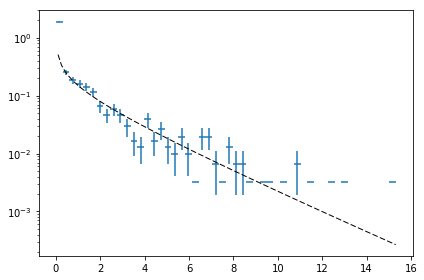

In [17]:
fig, ax = plt.subplots ()
h = many_results.get_hist (bins=50)
hl.plot1d (ax, h.normalize (), crosses=True)
x = np.linspace (.1, h.range[0][-1], 100)
ax.semilogy (x, many_results.eta * many_results.chi2.pdf (x), 'k--', lw=1)
plt.tight_layout ()

In [18]:
sens = tr.find_n_sig (many_results.median (), 0.9, batch_size=500, tol=0.03)

Start time: 2018-11-07 13:55:43.863490
Using 15 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.108...
  n_sig = 3.000 ... frac = 0.74000
  n_sig = 6.000 ... frac = 0.86000
  n_sig = 9.000 ... frac = 0.92000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    2.70    5.40    8.10   10.80   13.50  | n_sig (relative error)
500      |         49.0%   78.0%   93.4%   97.4%   98.8%   99.2%  |      4.508 (+/-  4.5%) [spline]
1000     |         50.3%   78.6%   91.7%   97.1%   99.1%   99.4%  |      4.878 (+/-  5.1%) [spline]
1500     |         48.5%   78.8%   91.0%   97.3%   99.1%   99.5%  |      5.088 (+/-  4.6%) [spline]
2000     |         48.5%   78.4%   91.1%   97.4%   99.2%   99.6%  |      5.049 (+/-  4.0%) [spline]
2500     |         49.2%   78.0%   91.2%   97.3%   99.0%   99.4%  |      5.051 (+/-  2.8%) [spline]
End time: 2018-11-07 13:59:00.598309
Elapsed time: 0:03:16.734819


In [19]:
sens['flux'] = tr.to_E2dNdE(sens['n_sig'],hyp.PowerLawFlux (2),100,1e3)

In [20]:
print(sens['flux'])

4.353747190550529e-13


In [11]:
def get_sens(ana,sindec,gamma,batch_size=500):
    src = utils.Sources(ra=0, dec = np.arcsin(sindec))
    flux = hyp.PowerLawFlux(gamma)
    tr = get_tr(src, ana, flux=flux)
    bg = tr.get_many_fits(500)
    bg = dists.Chi2TSD(bg, floc=0)
    sens = tr.find_n_sig(bg.median(),0.9,batch_size=batch_size,max_batch_size=1000,tol=0.03) #firstbatchsize=100 or covereage=2
    sens['flux'] = tr.to_E2dNdE(sens['n_sig'],hyp.PowerLawFlux (2),100,1e3)
    return sens['flux']

In [12]:
def get_sens_mese(ana,sindec,gamma,batch_size=500):
    src = utils.Sources(ra=0, dec = np.arcsin(sindec))
    flux = hyp.PowerLawFlux(gamma)
    tr = get_tr(src, ana, flux=flux)
    bg = tr.get_many_fits(500)
    bg = dists.Chi2TSD(bg, floc=0)
    sens = tr.find_n_sig(bg.median(),0.9,batch_size=batch_size,max_batch_size=1000,tol=0.03) #firstbatchsize=100 or covereage=2
    sens['flux'] = tr.to_E2dNdE(sens['n_sig'],hyp.PowerLawFlux (2),100,1e3)
    return sens['flux']

def get_discovery_mese(ana,sindec,gamma,batch_size=500):
    src = utils.Sources(ra=0, dec = np.arcsin(sindec))
    flux = hyp.PowerLawFlux(gamma)
    tr = get_tr(src, ana, flux=flux)
    bg = tr.get_many_fits(500)
    bg = dists.Chi2TSD(bg, floc=0)
    sens = tr.find_n_sig(bg.isf_nsigma(5,fit=True),0.5,batch_size=batch_size,max_batch_size=1000,tol=0.03) #firstbatchsize=100 or covereage=2
    sens['flux'] = tr.to_E2dNdE(sens['n_sig'],hyp.PowerLawFlux (2),100,1e3)
    return sens['flux']

In [13]:

sens_arb = get_sens(ana_7,0,2)


Performing 500 background trials using 15 cores:
        500/500 trials complete.   
Start time: 2019-02-12 07:53:19.227812
Using 15 cores.
* Starting initial scan for 90% of 50 trials with TS >= 2.930...
  n_sig = 3.000 ... frac = 0.78000
  n_sig = 6.000 ... frac = 0.92000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    1.80    3.60    5.40    7.20    9.00  | n_sig (relative error)
500      |         52.4%   66.8%   80.4%   86.4%   91.0%   96.4%  |      6.819 (+/-  7.0%) [spline]
1000     |         50.5%   67.9%   80.8%   88.7%   91.4%   96.6%  |      6.210 (+/-  9.7%) [spline]
End time: 2019-02-12 07:54:17.565664
Elapsed time: 0:00:58.337852


In [30]:
print(sens_arb)

3.891464989757494e-13


In [40]:
dec_array = np.linspace(-0.9,0.9,5)
sens_list = []

sens = [get_sens(ana_7,dec, gamma=2) for dec in decarray]

    

Performing 500 background trials using 15 cores:
        500/500 trials complete.   
Start time: 2018-11-05 15:37:30.994090
Using 15 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.055...
  n_sig = 3.000 ... frac = 0.90000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    0.90    1.80    2.70    3.60    4.50  | n_sig (relative error)
500      |         49.0%   66.0%   76.2%   85.8%   88.8%   89.8%  |        inf (+/-  0.0%) [chi2.cdf]
End time: 2018-11-05 15:38:00.130488
Elapsed time: 0:00:29.136398
Performing 500 background trials using 15 cores:
        500/500 trials complete.   
Start time: 2018-11-05 15:38:05.200355
Using 15 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.025...
  n_sig = 3.000 ... frac = 0.90000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    0.90    1.80    2.70    3.60    4.50  | n_sig (relative error)
500      |         44.8%   62.0%   71.6%   78.6%   87.4%   91.6%  |      4.055 (+/-  5.1%) [sp

500      |         48.6%   70.6%   80.8%   87.6%   92.4%   95.4%  |      6.211 (+/-  6.3%) [spline]
1000     |         47.9%   69.3%   81.0%   86.2%   92.9%   96.0%  |      6.360 (+/-  3.9%) [spline]
End time: 2018-11-05 15:52:40.679646
Elapsed time: 0:01:18.004333
Performing 500 background trials using 15 cores:
        500/500 trials complete.   
Start time: 2018-11-05 15:52:46.877956
Using 15 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.091...
  n_sig = 3.000 ... frac = 0.84000
  n_sig = 6.000 ... frac = 0.86000
  n_sig = 9.000 ... frac = 0.94000
* Generating batches of 500 trials...
n_trials | n_inj    0.00    2.70    5.40    8.10   10.80   13.50  | n_sig (relative error)
500      |         55.0%   76.8%   86.2%   94.8%   97.4%   99.6%  |      6.443 (+/-  5.5%) [spline]
1000     |         53.4%   76.6%   87.0%   95.1%   97.6%   99.0%  |      6.253 (+/-  3.7%) [spline]
End time: 2018-11-05 15:54:07.097970
Elapsed time: 0:01:20.220014
Performing 500 background tri

In [22]:
dec_array_3 = np.linspace(-0.9,0.9,10)
mese_sens_list = []


np.save('test.npy',dec_array_3)
print(dec_array_3)
#for dec in dec_array_3:
#    sensitivity = get_sens_mese(dec,2)
#    mese_sens_list.append(sensitivity)

[-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7  0.9]


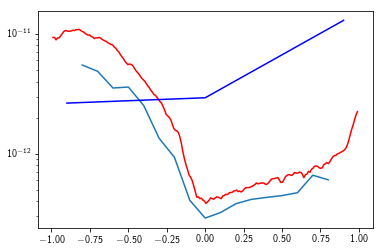

In [53]:
plt.semilogy(dec_array,sens_list)
sd,phi = repo.get_performance('sens_E200_ps7yr')[:2]
plt.semilogy(sd,phi,color='r')
plt.semilogy(dec_array_3,mese_sens_list,color='b')

# Galactic Plane

In [9]:
ana7 = analysis.Analysis (repo, selections.PSDataSpecs.ps_7yr, dir=ana_dir)

Setting up Analysis for:
IC40, IC59, IC79, IC86_2011, IC86_2012_2014
Setting up IC40...
<- /data/user/drysewyk/csky_cache/ana/IC40.subanalysis.npy    
Setting up IC59...
<- /data/user/drysewyk/csky_cache/ana/IC59.subanalysis.npy    
Setting up IC79...
<- /data/user/drysewyk/csky_cache/ana/IC79.subanalysis.npy    
Setting up IC86_2011...
<- /data/user/drysewyk/csky_cache/ana/IC86_2011.subanalysis.npy    
Setting up IC86_2012_2014...
<- /data/user/drysewyk/csky_cache/ana/IC86_2012_2014.subanalysis.npy    
Done.


In [10]:
def get_llh_map (a, map, fit_gamma, dir):
    flux = hyp.PowerLawFlux (2.5)
    if not fit_gamma:
        acc_param = a.get_custom_flux_acc_parameterization (flux)
        energy_model = a.get_custom_flux_energy_pdf_ratio_model (flux)
    else:
        acc_param = a.acc_param
        energy_model = a.energy_pdf_ratio_model
    space_model = pdf.TemplateSpacePDFRatioModel (
        a, map, a.bg_space_param, acc_param, sigsub=True,
        flux=hyp.PowerLawFlux (2.5), fast_weight=True, dir=dir)
    pdf_ratio_model = pdf.MultiPDFRatioModel (space_model, energy_model)
    llh_model = llh.LLHModel (pdf_ratio_model, len (a.data), sigsub=True)
    return llh_model

def get_injs_map (a, llh_model):
    keep = llh_model.pdf_ratio_model.keep
    t = inj.DataInjector (a, a.data, keep, randomizers=[])
    b = inj.DataInjector (a, a.data, keep)
    s = inj.TemplateInjector (a, llh_model.pdf_ratio_model.acc_weighted_model, keep)
    return t, b, s

def get_tr_map (map, ana=ana7, fit_gamma=True, dir='', ns_min=0, mp_cpus=mp_cpus):
    llh_kw = dict (map=map, fit_gamma=fit_gamma, dir=dir)
    inj_kw = dict ()
    fitter_args = dict (_ns_min=ns_min)
    return trial.get_trial_runner (
        ana, get_llh_map, get_injs_map,
        llh_kw=llh_kw, inj_kw=inj_kw,
        fitter_args=fitter_args, mp_cpus=mp_cpus)


In [11]:
pi0_dir = '/data/user/drysewyk/csky_cache/templates/pi0'
map_pi0 = repo.get_template ('Fermi-LAT_pi0_map')

Reading /data/user/mrichman/data/analyses/templates/Fermi-LAT_pi0_map.npy ...


In [12]:
tr_pi0_E250 = get_tr_map (map_pi0, fit_gamma=False, ns_min=-5, dir=pi0_dir)

<- /data/user/drysewyk/csky_cache/templates/pi0/IC40.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC59.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC79.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC86_2011.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC86_2012_2014.template.fastweight.npy    
Restore successful.


In [13]:
tr_pi0_E250.get_one_fit (TRUTH=False)

[4.7844330080062045, 593.1800856983913]

In [14]:
bg_trials = tr_pi0_E250.get_many_fits (250)

Performing 250 background trials using 15 cores:
        250/250 trials complete.   


In [15]:
bg_trials = dists.Chi2TSD(bg_trials)

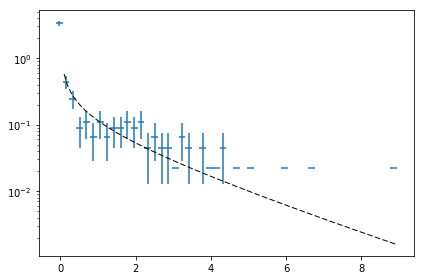

In [16]:
fig, ax = plt.subplots ()
h = bg_trials.get_hist (bins=50)
hl.plot1d (ax, h.normalize (), crosses=True)
x = np.linspace (.1, h.range[0][-1], 100)
ax.semilogy (x, bg_trials.eta * bg_trials.chi2.pdf (x), 'k--', lw=1)
plt.tight_layout ()

In [17]:
tr_pi0_gammatrue = get_tr_map (map_pi0, fit_gamma=True, ns_min=-5, dir=pi0_dir)

<- /data/user/drysewyk/csky_cache/templates/pi0/IC40.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC59.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC79.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC86_2011.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC86_2012_2014.template.fastweight.npy    
Restore successful.


In [ ]:
bg_trials_gammatrue = tr_pi0_gammatrue.get_many_fits (250)

Performing 250 background trials using 15 cores:
        206/250 trials complete...

In [35]:
def get_sens_map(map,fit_gamma = False,batch_size=500):
    tr = get_tr_map(map,dir = pi0_dir,ns_min=-5)
    bg = tr.get_many_fits(250)
    bg = dists.Chi2TSD(bg, floc=0)
    sens = tr.find_n_sig(bg.median(),0.9,batch_size=batch_size,max_batch_size=1000,tol=0.03) #firstbatchsize=100 or covereage=2
    sens['flux'] = tr.to_E2dNdE(sens['n_sig'],hyp.PowerLawFlux (2.5),100,1e3)
    return sens['flux']

In [37]:
sens_map = get_sens_map(map_pi0,fit_gamma=False)

<- /data/user/drysewyk/csky_cache/templates/pi0/IC40.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC59.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC79.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC86_2011.template.fastweight.npy    
Restore successful.
<- /data/user/drysewyk/csky_cache/templates/pi0/IC86_2012_2014.template.fastweight.npy    
Restore successful.
Performing 250 background trials using 15 cores:
        250/250 trials complete.   
Start time: 2018-11-06 09:59:17.452901
Using 15 cores.
* Starting initial scan for 90% of 50 trials with TS >= 0.985...
  n_sig = 3.000 ... frac = 0.56000
  n_sig = 6.000 ...
KeyboardInterrupt: terminating early.


IndexError: too many indices for array